In [5]:
#Clustering + PCA

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

#Load data
df = pd.read_csv("../data/simulated_gene_data.csv")
X = df[["gc_content", "expression"]].values

#Standardize features 
scaler = StandardScaler()
Xz = scaler.fit_transform(X)

df.head()


,gene_id,population,gc_content,expression
0,Osaka_gene_001,Osaka,41.24,7.78
1,Osaka_gene_002,Osaka,34.68,10.64
2,Osaka_gene_003,Osaka,31.74,10.56
3,Osaka_gene_004,Osaka,51.24,12.02
4,Osaka_gene_005,Osaka,30.62,8.84


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(
C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

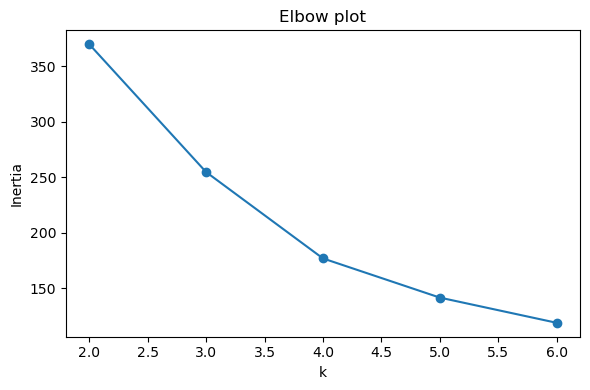

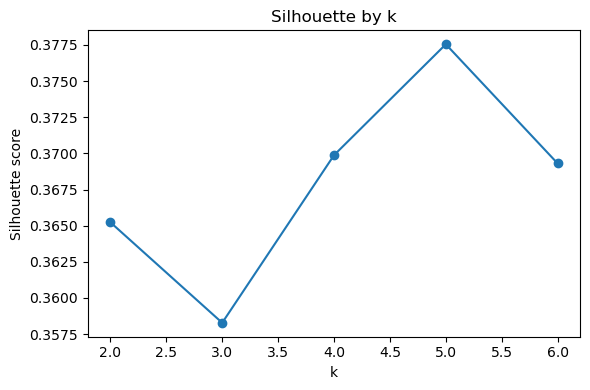

[(2, 0.3652313338642071),
 (3, 0.3582775099949145),
 (4, 0.36987470386432253),
 (5, 0.3775506966290343),
 (6, 0.3693047288767468)]

In [6]:
#Elbow + silhouette, justify k

ks = range(2, 7)
inertia, sil = [], []

for k in ks:
    km = KMeans(n_clusters=k, n_init=25, random_state=42)
    labels = km.fit_predict(Xz)
    inertia.append(km.inertia_)
    sil.append(silhouette_score(Xz, labels))

#Elbow
plt.figure(figsize=(6,4))
plt.plot(list(ks), inertia, marker="o")
plt.xlabel("k"); plt.ylabel("Inertia"); plt.title("Elbow plot")
plt.tight_layout(); plt.savefig("../results/elbow.png", dpi=300); plt.show()

#Silhouette
plt.figure(figsize=(6,4))
plt.plot(list(ks), sil, marker="o")
plt.xlabel("k"); plt.ylabel("Silhouette score"); plt.title("Silhouette by k")
plt.tight_layout(); plt.savefig("../results/silhouette.png", dpi=300); plt.show()

list(zip(ks, sil))


In [7]:
#Interpretation

#As the simulated Osaka, Barcelona and Okinawa datasets were drawn from identical distributions, the clustering results do not strongly align with the true population labels. The elbow curve suggests diminishing returns beyond k=3, but the silhouette score peaks at k=5, indicating that the algorithm detects fine-scale variation rather than distinct population separation.

#This error bar shown above was expected as there is **no real population-level signal** in the current dataset.

#If small shifts were introfuced in GC content or expression for each population (e.g., slightly higher mean GC% in Barcelona, lower expression mean in Okinawa), the optimal k would move closer to 3 and clusters would align more strongly with populations. This would better mimic cryptic speciation where lineages share morphology but diverge genetically.


In [8]:
#Fit KMeans (k=3), add labels

k = 3
km = KMeans(n_clusters=k, n_init=25, random_state=42)
df["cluster"] = km.fit_predict(Xz)
centroids = km.cluster_centers_
centroids


C:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=2.
  warnings.warn(


array([[-0.02276633,  1.19570646],
       [ 0.87547696, -0.51502545],
       [-0.95062882, -0.39350228]])

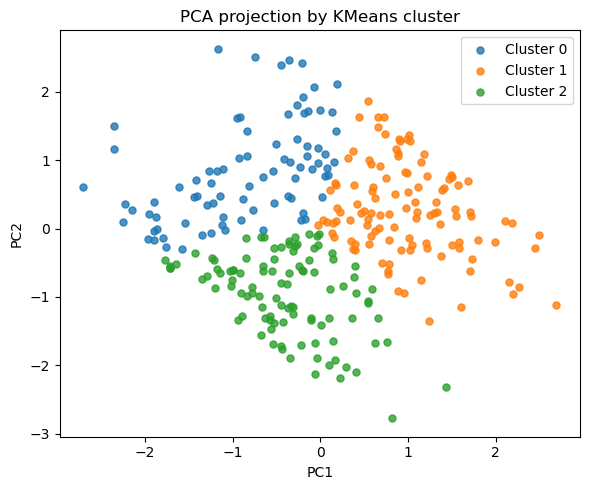

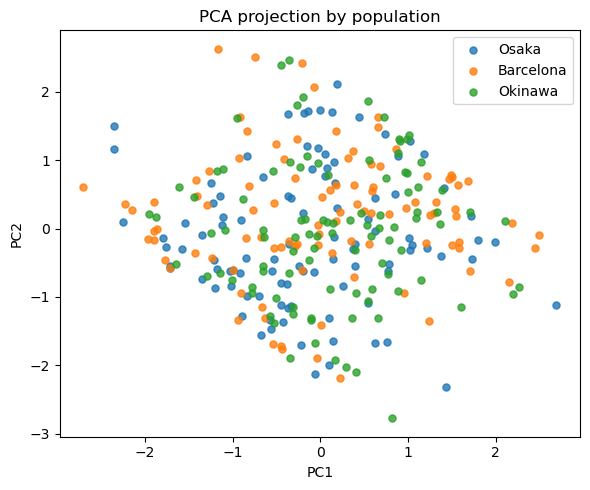

In [9]:
#PCA projection by cluster vs by population

pca = PCA(n_components=2, random_state=42)
Xp = pca.fit_transform(Xz)

#Colored by cluster

plt.figure(figsize=(6,5))
for c in sorted(df["cluster"].unique()):
    idx = df["cluster"] == c
    plt.scatter(Xp[idx,0], Xp[idx,1], s=26, alpha=0.8, label=f"Cluster {c}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA projection by KMeans cluster")
plt.legend(); plt.tight_layout()
plt.savefig("../results/pca_by_cluster.png", dpi=300); plt.show()

#Colored by true population

plt.figure(figsize=(6,5))
for pop in df["population"].unique():
    idx = df["population"] == pop
    plt.scatter(Xp[idx,0], Xp[idx,1], s=26, alpha=0.8, label=pop)
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.title("PCA projection by population")
plt.legend(); plt.tight_layout()
plt.savefig("../results/pca_by_population.png", dpi=300); plt.show()


In [10]:
#Population vs cluster table & quick purity metric

ct = pd.crosstab(df["population"], df["cluster"])
ct.to_csv("../results/population_vs_cluster_table.csv")
ct

majority_sum = 0
for c in sorted(df["cluster"].unique()):
    col = ct.iloc[:, c]
    majority_sum += col.max()
purity = majority_sum / len(df)
print(f"Approx. cluster purity: {purity:.3f}")

Approx. cluster purity: 0.393


In [ ]:
### Conclusion
The baseline dataset used here draws all three populations (Osaka, Barcelona, Okinawa) from identical distributions. As expected, clustering performance was weak:

- Silhouette peaked at k=5 instead of k=3
- PCA projections showed overlapping populations
- Cluster purity was low (~0.39)

This illustrates an important principle: **without underlying population-specific signal, cryptic speciation cannot be detected** by unsupervised clustering. 

                                       In real *Oikopleura dioica* datasets, lineage-specific shifts in GC content, gene order or expression provide exactly this signal. If such shifts are simulated, clustering recovers k=3 and aligns much more strongly with populations which mimics cryptic speciation detection.
